In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

distribution = pd.read_csv('wcvp_distribution.csv')
names = pd.read_csv('wcvp_names.csv', low_memory=False)

In [3]:
distribution.isnull().sum()

plant_locality_id      0
plant_name_id          0
continent_code_l1      0
continent              0
region_code_l2       100
region               100
area_code_l3         710
area                 711
introduced             0
extinct                0
location_doubtful      0
dtype: int64

In [4]:
columns = ['region_code_l2', 'region', 'area_code_l3', 'area']
distribution_cleaned = distribution.dropna(subset=columns)
print(distribution_cleaned.isnull().sum())

plant_locality_id    0
plant_name_id        0
continent_code_l1    0
continent            0
region_code_l2       0
region               0
area_code_l3         0
area                 0
introduced           0
extinct              0
location_doubtful    0
dtype: int64


In [5]:
unique_region = distribution_cleaned['region'].unique()

In [6]:
# Initialize geocoder
geolocator = Nominatim(user_agent="geoproject")

# Initialize DataFrame with specified columns
region_df = pd.DataFrame(columns=['location', 'latitude', 'longitude'])

# List to track failed geocoding attempts
failed_locations = []

# Function to handle geocoding with retries
def do_geocode(location):
    try:
        return geolocator.geocode(location, timeout=10)
    except GeocoderTimedOut:
        return do_geocode(location)

# Geocode each location and append to DataFrame
for location in unique_region:
    loc = do_geocode(location)
    if loc:
        region_df = pd.concat([region_df, pd.DataFrame([{'location': location, 'latitude': loc.latitude, 'longitude': loc.longitude}])], ignore_index=True)
    else:
        failed_locations.append(location)

print(region_df)

# Print locations that failed to geocode
print("Failed to geocode the following locations:")
print(failed_locations)

C:\Users\USER\AppData\Local\Temp\ipykernel_12156\985872683.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  region_df = pd.concat([region_df, pd.DataFrame([{'location': location, 'latitude': loc.latitude, 'longitude': loc.longitude}])], ignore_index=True)


                  location   latitude   longitude
0          Central America -30.292848  153.125616
1    Western South America  41.875523  -87.688619
2                   Brazil -10.333333  -53.200000
3   Southern South America  34.865524  -82.419007
4                  Malesia   4.569375  102.265682
5     Northwestern Pacific  38.106694 -122.565154
6      Southeastern Europe  49.014879   12.102994
7           Eastern Europe  50.265903   18.697576
8              Macaronesia  28.250000  -17.000000
9    South Tropical Africa -30.292578  153.124407
10         Southern Africa  37.875092 -122.237521
11                 Siberia   5.891683  -75.930073
12             Middle Asia  22.320664  114.186169
13                Caucasus  42.491374   44.996125
14            Western Asia   9.602177  122.467099
15       Arabian Peninsula  22.374251   49.477089
16                   China  35.000074  104.999927
17            Eastern Asia  21.420104   39.893096
18     Indian Subcontinent  20.000000   78.000000


In [7]:
# Manually geocoded failed locations
manual_geocodes = {
    "Northern South America": (4.5709, -74.2973),
    "Papuasia": (-6.314993, 143.95555),
    "Southwestern Pacific": (-18.1425999, 178.4419499),
    "West Tropical Africa": (7.3697, -5.5353),
    "West-Central Tropical Africa": (-0.2280, 15.8277),
    "Northeast Tropical Africa": (12.6500, 39.6333),
    "East Tropical Africa": (-6.3690, 34.8888),
    "Middle Atlantic Ocean": (-14.5994, -28.6731),
    "Western Indian Ocean": (-12.5, 43.4),
    "Russian Far East": (60.0000, 105.0000),
    "Subarctic America": (58.3019, -134.4197),
    "Subantarctic Islands": (-54.4296, -36.5879),
    "Antarctic Continent": (-82.8628, 135.0000)
}

# Appendding manually geocoded locations to the DataFrame
for location, (lat, lon) in manual_geocodes.items():
    region_df = pd.concat([region_df, pd.DataFrame([{'location': location, 'latitude': lat, 'longitude': lon}])], ignore_index=True)

print("Final DataFrame with manually geocoded locations:")
print(region_df)

Final DataFrame with manually geocoded locations:
                        location   latitude   longitude
0                Central America -30.292848  153.125616
1          Western South America  41.875523  -87.688619
2                         Brazil -10.333333  -53.200000
3         Southern South America  34.865524  -82.419007
4                        Malesia   4.569375  102.265682
5           Northwestern Pacific  38.106694 -122.565154
6            Southeastern Europe  49.014879   12.102994
7                 Eastern Europe  50.265903   18.697576
8                    Macaronesia  28.250000  -17.000000
9          South Tropical Africa -30.292578  153.124407
10               Southern Africa  37.875092 -122.237521
11                       Siberia   5.891683  -75.930073
12                   Middle Asia  22.320664  114.186169
13                      Caucasus  42.491374   44.996125
14                  Western Asia   9.602177  122.467099
15             Arabian Peninsula  22.374251   49.47708

In [8]:
# Merge the DataFrames on the 'Region' and 'Location' columns
new_distribution = pd.merge(distribution_cleaned, region_df, left_on='region', right_on='location', how='left')

# Drop the redundant 'Location' column if necessary
new_distribution.drop(columns=['location'], inplace=True)


In [9]:
final_dataset = pd.merge(new_distribution, names, on='plant_name_id', how='left')

# dropping redundant or unwanted columns
final_dataset.drop(columns=['infraspecific_rank', 'infraspecies', 'nomenclatural_remarks', 'replaced_synonym_author', 'homotypic_synonym', 'hybrid_formula', 'basionym_plant_name_id', 'parenthetical_author', 'parent_plant_name_id'], inplace=True)



In [10]:
final_dataset.isnull().sum()

plant_locality_id              0
plant_name_id                  0
continent_code_l1              0
continent                      0
region_code_l2                 0
region                         0
area_code_l3                   0
area                           0
introduced                     0
extinct                        0
location_doubtful              0
latitude                       0
longitude                      0
ipni_id                   118518
taxon_rank                117831
taxon_status              117831
family                    117831
genus                     117831
species                   198185
primary_author            173055
place_of_publication      117831
volume_and_page           173425
first_published           173418
geographic_area           118001
lifeform_description      241663
climate_description       204631
taxon_name                117831
taxon_authors             173055
accepted_plant_name_id    123688
powo_id                   117831
reviewed  

In [11]:
final_dataset.describe(include='object')

,continent,region,area_code_l3,area,ipni_id,taxon_rank,taxon_status,family,genus,species,...,place_of_publication,volume_and_page,first_published,geographic_area,lifeform_description,climate_description,taxon_name,taxon_authors,powo_id,reviewed
count,1047864,1047864,1047864,1047864,929346,930033,930033,930033,930033,849679,...,930033,874439,874446,929863,806201,843233,930033,874809,930033,930032
unique,9,52,368,368,220547,9,2,391,8564,70168,...,5738,77899,623,41123,326,8,220583,52145,220715,2
top,SOUTHERN AMERICA,Western South America,CLM,Colombia,330001-2,Species,Accepted,Poaceae,Carex,palustris,...,Sp. Pl.,: [s.p.],-1753,Tropics & Subtropics,perennial,temperate,Cyperus,L.,330001-2,Y
freq,224335,56844,18122,18122,329,753756,924176,123032,23519,2701,...,95200,2036,95223,12160,154312,276993,329,103307,329,713131


In [12]:
to_dropna = ['family', 'genus', 'species']
final_dataset_cleaned = final_dataset.dropna(subset=to_dropna)

In [13]:
final_dataset_cleaned.isnull().sum()

plant_locality_id             0
plant_name_id                 0
continent_code_l1             0
continent                     0
region_code_l2                0
region                        0
area_code_l3                  0
area                          0
introduced                    0
extinct                       0
location_doubtful             0
latitude                      0
longitude                     0
ipni_id                     687
taxon_rank                    0
taxon_status                  0
family                        0
genus                         0
species                       0
primary_author            55224
place_of_publication          0
volume_and_page           55594
first_published           55587
geographic_area              91
lifeform_description      44358
climate_description        7968
taxon_name                    0
taxon_authors             55224
accepted_plant_name_id     5857
powo_id                       0
reviewed                      1
dtype: i

## Visualizing Species density with Heat map

In [14]:
# Remove duplicates to ensure each species-location pair is unique
unique_species_data = final_dataset_cleaned.drop_duplicates(subset=['species', 'latitude', 'longitude'])
print(unique_species_data.shape)

(201867, 31)


In [ ]:
from folium.plugins import HeatMap

# Creating a base map
m = folium.Map(location=[0, 0], zoom_start=2)

# Adding heatmap with unique species
heat_data = [[row['latitude'], row['longitude']] for index, row in unique_species_data.iterrows()]
HeatMap(heat_data).add_to(m)

# Save the heatmap to an HTML file
m.save('unique_species_density_heatmap.html')

# Display the heatmap
m

## Plotting Unique Species Count per Continent

continent
AFRICA              16977
ANTARCTICA            294
ASIA-TEMPERATE      16472
ASIA-TROPICAL       20124
AUSTRALASIA          7463
EUROPE               7851
NORTHERN AMERICA    10420
PACIFIC              3852
SOUTHERN AMERICA    27278
Name: species, dtype: int64


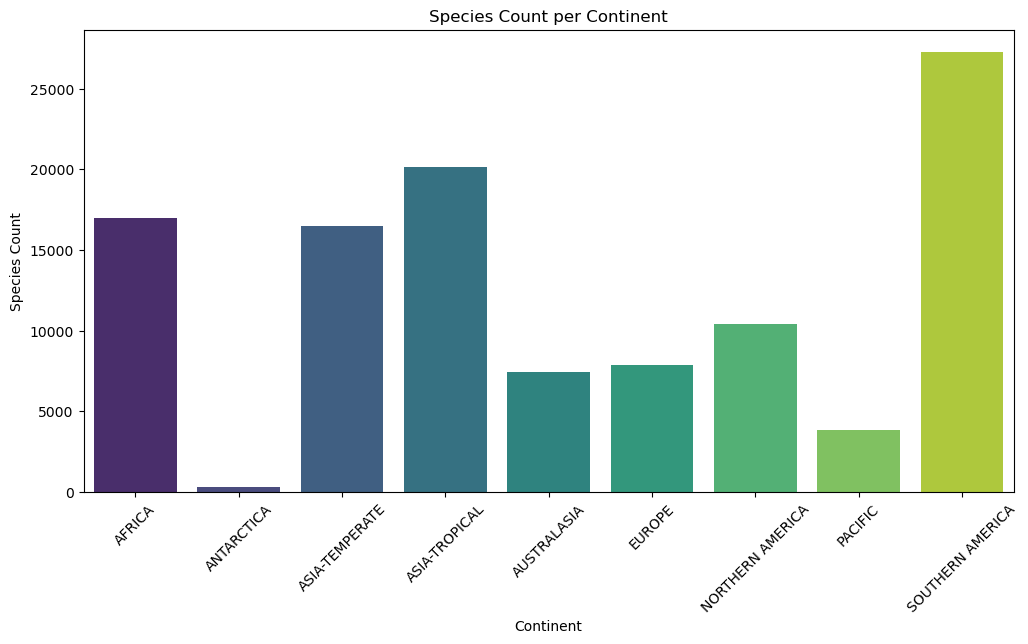

In [17]:
# Counting unique species per continent
continent_species_counts = final_dataset_cleaned.groupby('continent')['species'].nunique()
print(continent_species_counts)
# Plotting unique species count per continent
plt.figure(figsize=(12, 6))
sns.barplot(x=continent_species_counts.index, y=continent_species_counts.values, palette="viridis")
plt.title('Species Count per Continent')
plt.xlabel('Continent')
plt.ylabel('Species Count')
plt.xticks(rotation=45)
plt.show()

region
Antarctic Continent                 3
Arabian Peninsula                1543
Australia                        7001
Brazil                          10965
Caribbean                        4658
Caucasus                         2347
Central America                  6605
China                            9303
East Tropical Africa             4811
Eastern Asia                     3771
Eastern Canada                   1482
Eastern Europe                   2255
Indian Subcontinent              6646
Indo-China                       7207
Macaronesia                      1473
Malesia                         10233
Mexico                           7463
Middle Asia                      2958
Middle Atlantic Ocean             335
Middle Europe                    2815
Mongolia                         1160
New Zealand                      1444
North-Central Pacific            1247
North-Central U.S.A.             2044
Northeast Tropical Africa        3655
Northeastern U.S.A.              2133
North

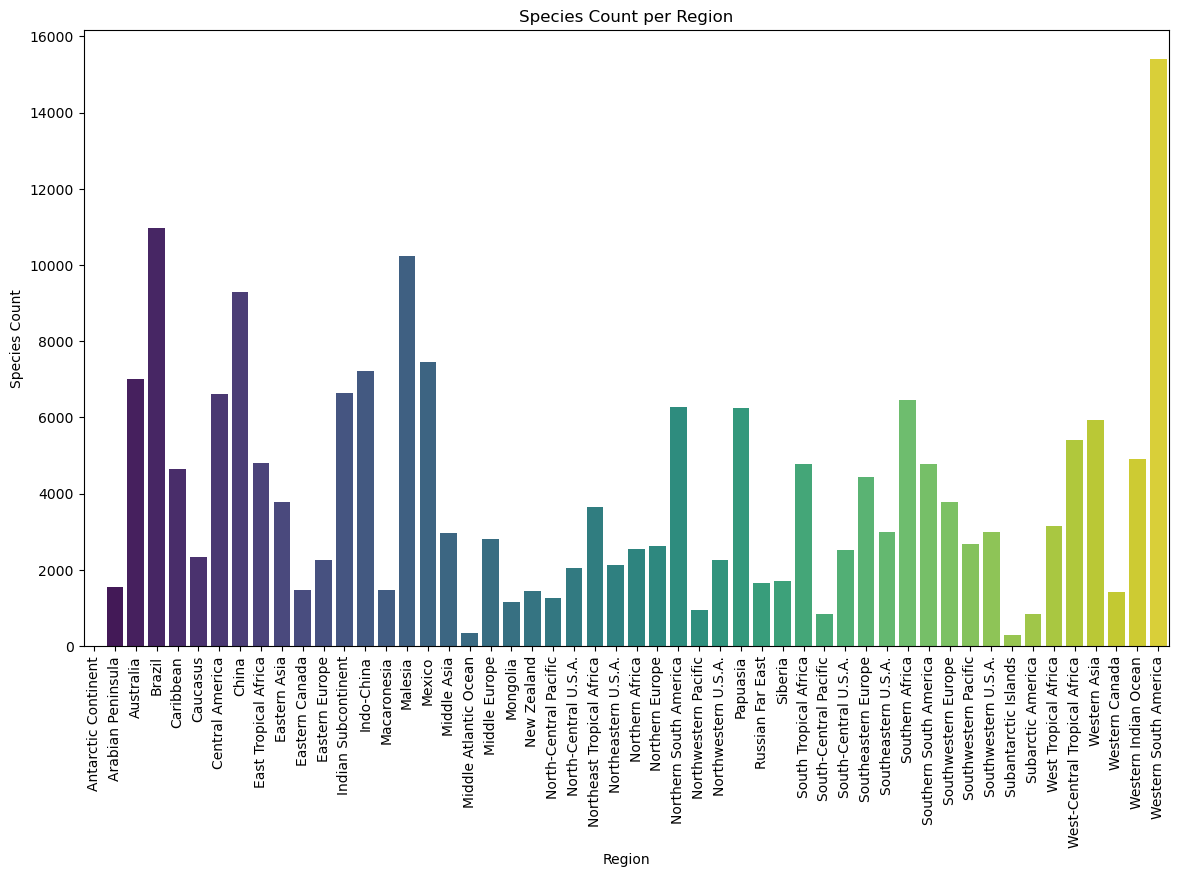

In [21]:
region_species_counts = final_dataset_cleaned.groupby('region')['species'].nunique()
print(region_species_counts)
# Plotting unique species count per region
plt.figure(figsize=(14, 8))
sns.barplot(x=region_species_counts.index, y=region_species_counts.values, palette="viridis")
plt.title('Species Count per Region')
plt.xlabel('Region')
plt.ylabel('Species Count')
plt.xticks(rotation=90)
plt.show()

## Interactive Geospatial Plots for Species Distribution

In [ ]:
# Creating a base map
m = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for each unique species-location pair
for index, row in unique_species_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['species']
    ).add_to(m)

# Save the map to an HTML file
m.save('unique_species_distribution_map.html')

# Display the map
m

continent
EUROPE              1516
AFRICA               813
NORTHERN AMERICA     431
SOUTHERN AMERICA     403
ASIA-TEMPERATE       349
ASIA-TROPICAL        321
PACIFIC              237
AUSTRALASIA          199
ANTARCTICA             4
dtype: int64


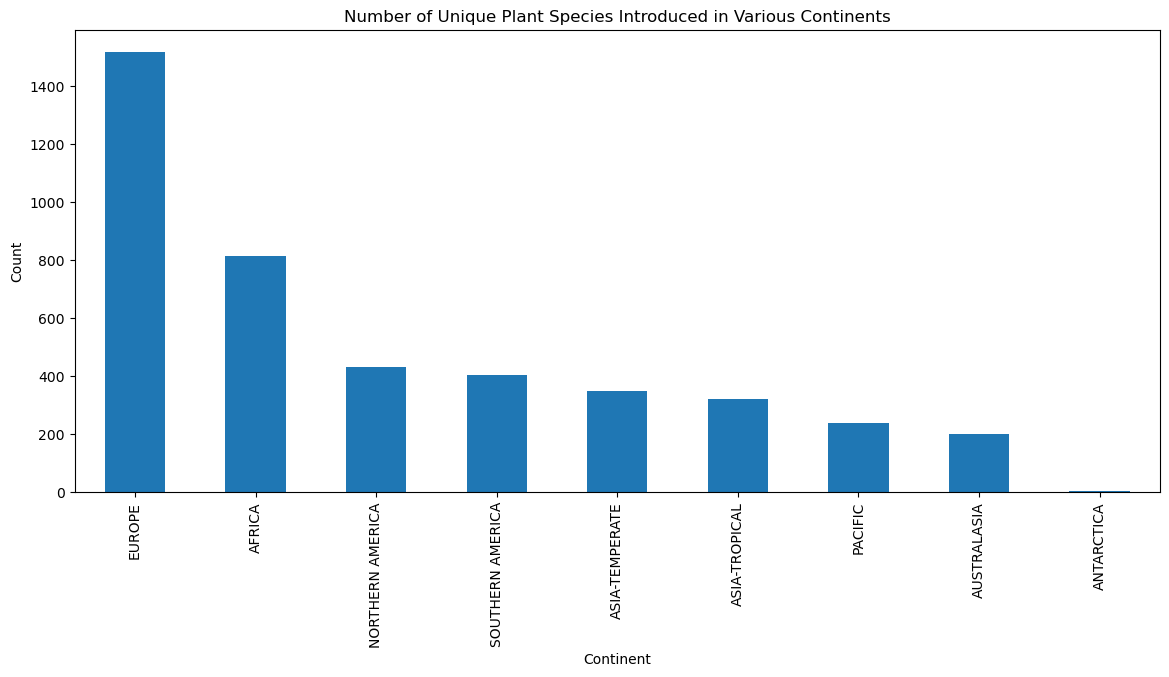

In [26]:
# Filter for introduced species
introduced_species = final_dataset_cleaned[final_dataset_cleaned['introduced'] == 1]

# Remove duplicate species based on their identifier
unique_introduced_species = introduced_species.drop_duplicates(subset='species')

# Group by continent and count unique introduced species
introduced_per_continent = unique_introduced_species.groupby('continent').size().sort_values(ascending=False)

print(introduced_per_continent)

# Plot number of unique plant species introduced in various continents
plt.figure(figsize=(14, 6))
introduced_per_continent.plot(kind='bar')
plt.title('Number of Unique Plant Species Introduced in Various Continents')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.show()


continent
EUROPE              208
AFRICA              201
ASIA-TROPICAL       159
NORTHERN AMERICA    127
SOUTHERN AMERICA     94
PACIFIC              71
ASIA-TEMPERATE       61
AUSTRALASIA          42
ANTARCTICA            1
dtype: int64


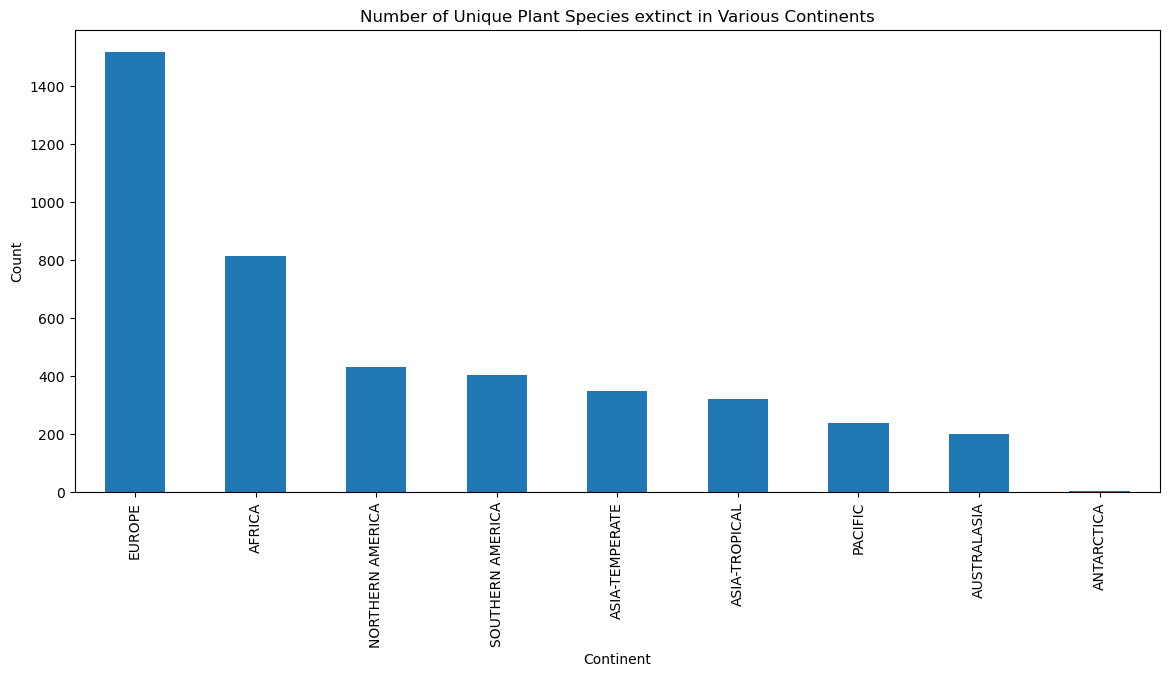

In [27]:
# Filter for introduced species
extinct_species = final_dataset_cleaned[final_dataset_cleaned['extinct'] == 1]

# Remove duplicate species based on their identifier
unique_extinct_species = extinct_species.drop_duplicates(subset='species')

# Group by continent and count unique introduced species
extinct_per_continent = unique_extinct_species.groupby('continent').size().sort_values(ascending=False)

print(extinct_per_continent)

# Plot number of unique plant species introduced in various continents
plt.figure(figsize=(14, 6))
introduced_per_continent.plot(kind='bar')
plt.title('Number of Unique Plant Species extinct in Various Continents')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.show()

## Clustering analysis on the geographical data

### By Location - Latitude and Longitude

In [28]:
# Ensure the data is unique by species and location
unique_species_data = final_dataset_cleaned.drop_duplicates(subset=['species', 'latitude', 'longitude'])
print(unique_species_data.shape)

(201867, 31)


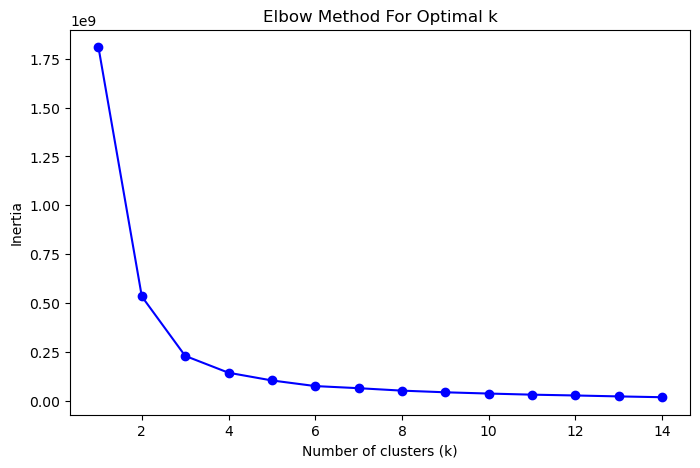

In [29]:
from sklearn.cluster import KMeans

# Extracting latitude and longitude for clustering
X = unique_species_data[['latitude', 'longitude']]

# Determine the optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3512842943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_species_data['Cluster'] = kmeans.labels_


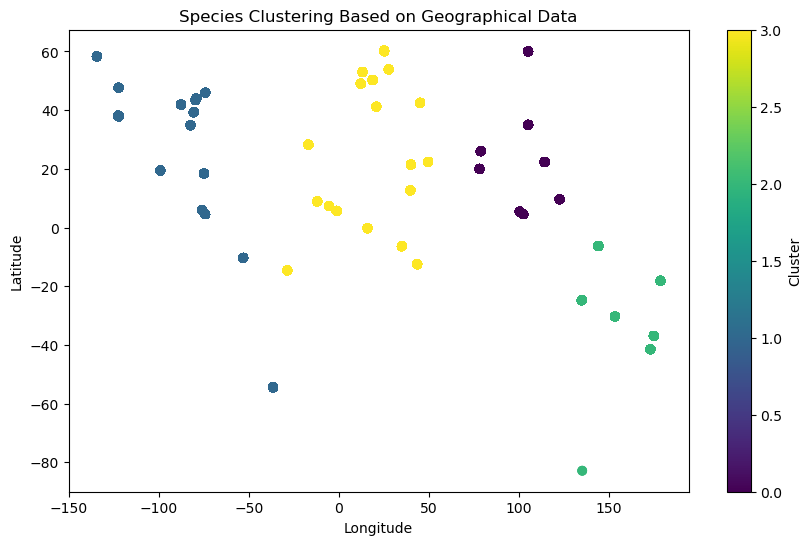

In [30]:
# Perform KMeans clustering
optimal_k = 4  # Replace with the determined optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10).fit(X)

# Add the cluster labels to the data
unique_species_data['Cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(unique_species_data['longitude'], unique_species_data['latitude'], c=unique_species_data['Cluster'], cmap='viridis', marker='o')
plt.colorbar(label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Species Clustering Based on Geographical Data')
plt.show()


In [ ]:
# Create a base map
m = folium.Map(location=[0, 0], zoom_start=2)

# Define a color map for 4 clusters
colors = ['red', 'blue', 'green', 'purple']


for index, row in unique_species_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"Species: {row['species']}\nCluster: {row['Cluster']}",
        color=colors[row['Cluster']],
        fill=True,
        fill_color=colors[row['Cluster']]
    ).add_to(m)

# Save the map to an HTML file
m.save('Species_clusters_map.html')


## By Region

In [31]:
species_count_per_region = final_dataset_cleaned.groupby('region')['species'].nunique().reset_index()
species_count_per_region.columns = ['region', 'speciescount']


In [32]:
final_df = final_dataset_cleaned.merge(species_count_per_region, on='region', how='left')


In [33]:
final_df.isnull().sum()

plant_locality_id             0
plant_name_id                 0
continent_code_l1             0
continent                     0
region_code_l2                0
region                        0
area_code_l3                  0
area                          0
introduced                    0
extinct                       0
location_doubtful             0
latitude                      0
longitude                     0
ipni_id                     687
taxon_rank                    0
taxon_status                  0
family                        0
genus                         0
species                       0
primary_author            55224
place_of_publication          0
volume_and_page           55594
first_published           55587
geographic_area              91
lifeform_description      44358
climate_description        7968
taxon_name                    0
taxon_authors             55224
accepted_plant_name_id     5857
powo_id                       0
reviewed                      1
speciesc

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
final_df['KMeans_Cluster'] = kmeans.fit_predict(final_df[['latitude', 'longitude', 'speciescount']])


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


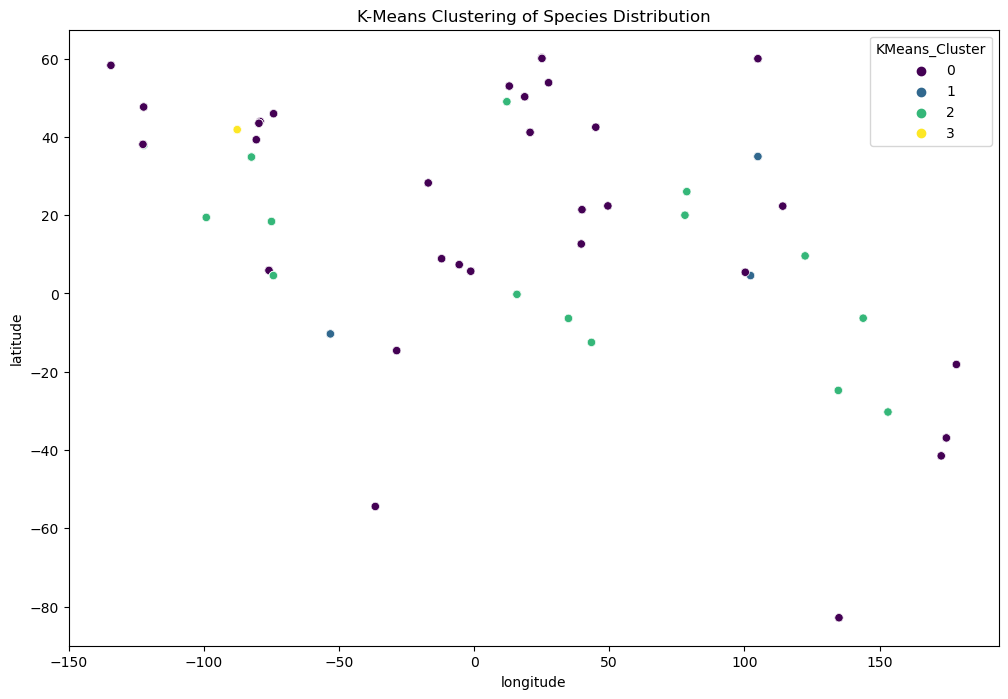

In [35]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=final_df, x='longitude', y='latitude', hue='KMeans_Cluster', palette='viridis')
plt.title('K-Means Clustering of Species Distribution')
plt.show()


# Kernel Density Estimation

C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


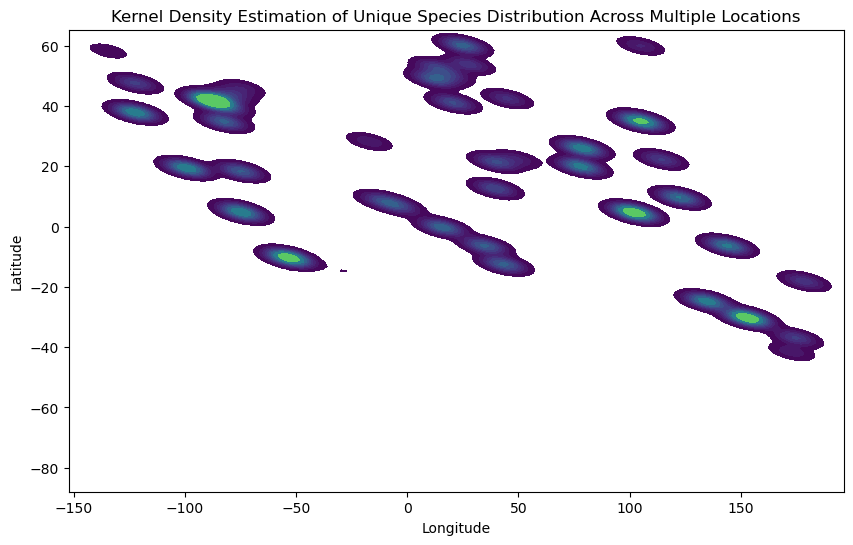

In [41]:
# Ensure each row represents a unique species-location pair
unique_species_locations = final_dataset_cleaned.drop_duplicates(subset=['species', 'latitude', 'longitude'])

# Extracting the latitude and longitude columns
latitudes = unique_species_locations['latitude']
longitudes = unique_species_locations['longitude']

# Plotting the KDE
plt.figure(figsize=(10, 6))
kde = sns.kdeplot(x=longitudes, y=latitudes, cmap="viridis", fill=True, bw_adjust=0.5)
plt.title('Kernel Density Estimation of Unique Species Distribution Across Multiple Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Spatial Autocorrelation

C:\Users\USER\AppData\Local\Temp\ipykernel_12156\2308373361.py:21: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(gdf)


Moran's I: 0.01604362370635751
P-value: 0.001


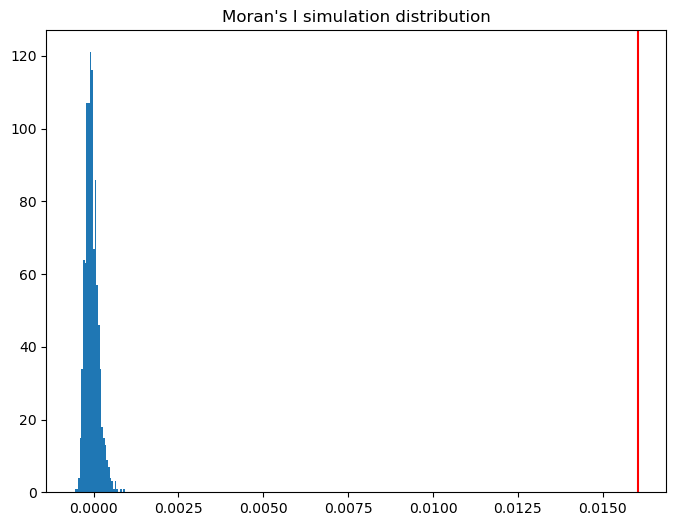

In [14]:
from esda.moran import Moran
from libpysal.weights import Queen
from shapely.geometry import Point

# Set the random seed for reproducibility
RANDOM_SEED = 42

# Assuming final_dataset_cleaned contains columns 'latitude', 'longitude', and 'species'

# Drop duplicates to ensure unique species per geographical point
unique_species_per_location = final_dataset_cleaned.drop_duplicates(subset=['species', 'longitude', 'latitude'])

# Sample the data to reduce size (e.g., 10% of the unique species per location data)
sample_size = int(len(unique_species_per_location) * 0.1)
sampled_species = unique_species_per_location.sample(n=sample_size, random_state=RANDOM_SEED)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(sampled_species, geometry=gpd.points_from_xy(sampled_species.longitude, sampled_species.latitude))

# Calculate spatial weights (using Queen contiguity as an example)
weights = Queen.from_dataframe(gdf)

# Ensure the variable is numeric
gdf['species_count'] = gdf.groupby('species')['species'].transform('count')

# Compute Moran's I
y = gdf['species_count'].values
moran = Moran(y, weights)

# Print Moran's I and p-value
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(moran.sim, bins=30)
plt.axvline(moran.I, color='r')
plt.title("Moran's I simulation distribution")
plt.show()



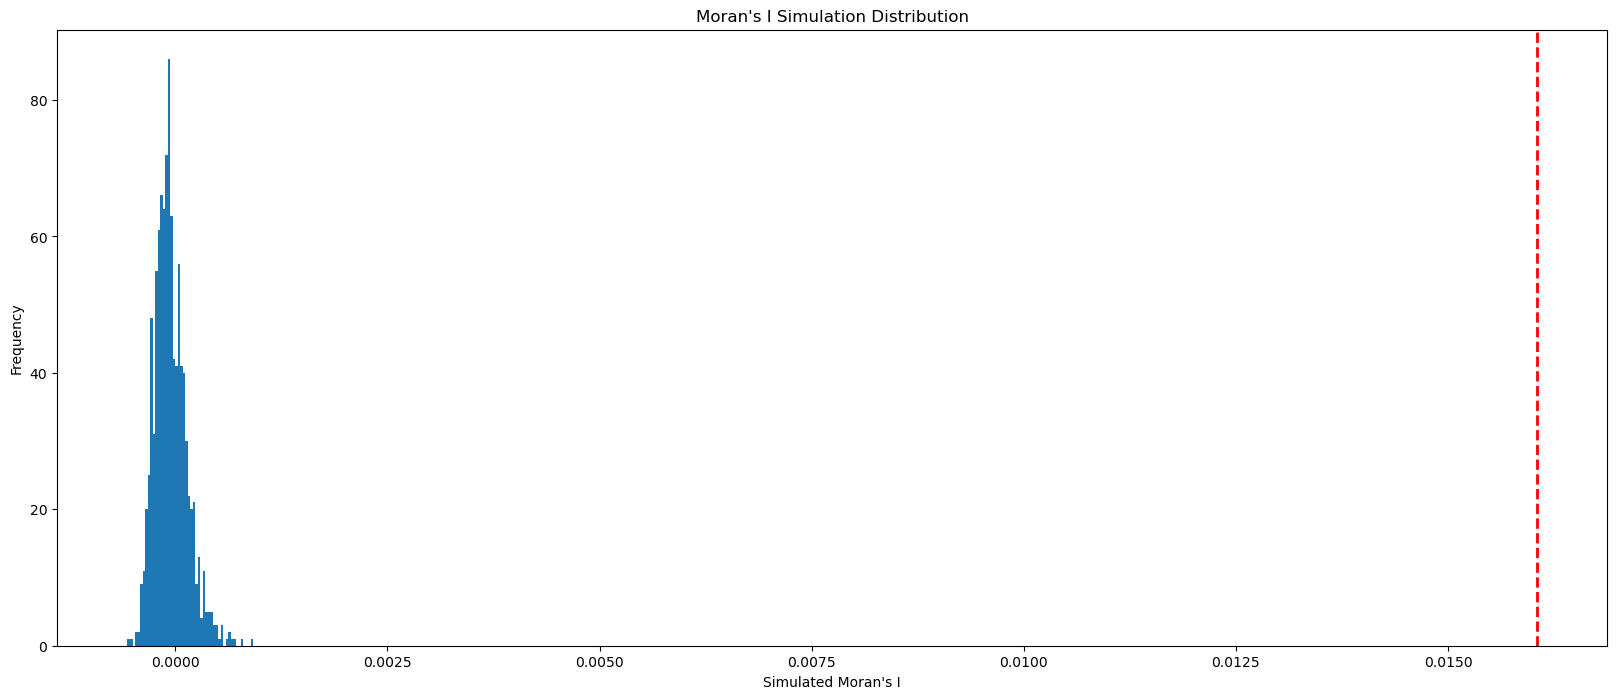

In [16]:
# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.hist(moran.sim, bins=50)
plt.axvline(moran.I, color='r', linestyle='dashed', linewidth=2)
plt.title("Moran's I Simulation Distribution")
plt.xlabel("Simulated Moran's I")
plt.ylabel("Frequency")
plt.show()

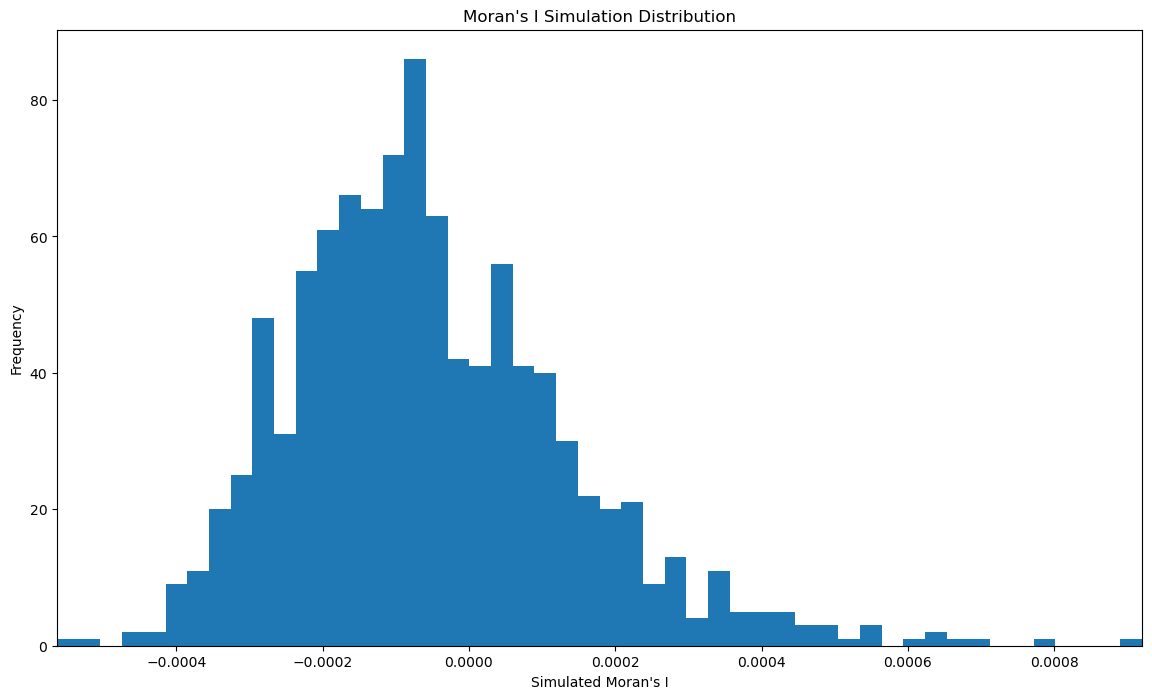

In [17]:
# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.hist(moran.sim, bins=50)
plt.axvline(moran.I, color='r', linestyle='dashed', linewidth=2)
plt.title("Moran's I Simulation Distribution")
plt.xlabel("Simulated Moran's I")
plt.ylabel("Frequency")
plt.xlim([min(moran.sim), max(moran.sim)])  # Adjust x-axis limits
plt.show()

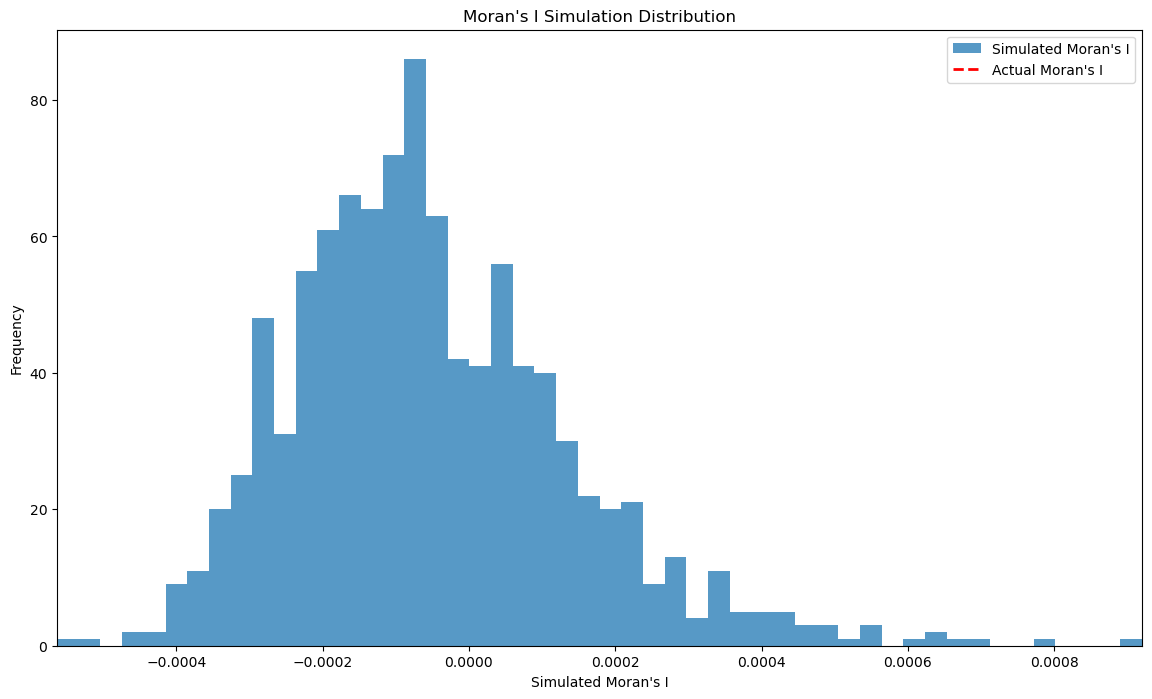

In [18]:
# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.hist(moran.sim, bins=50, alpha=0.75, label='Simulated Moran\'s I')
plt.axvline(moran.I, color='r', linestyle='dashed', linewidth=2, label='Actual Moran\'s I')
plt.title("Moran's I Simulation Distribution")
plt.xlabel("Simulated Moran's I")
plt.ylabel("Frequency")
plt.xlim([min(moran.sim), max(moran.sim)])  # Adjust x-axis limits
plt.legend()
plt.show()

AttributeError: 'NoneType' object has no attribute 'to_string'

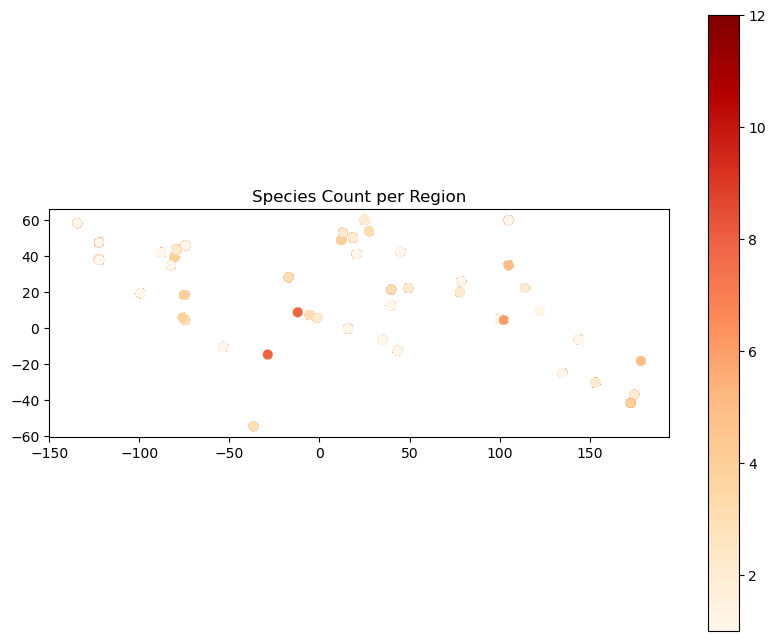

In [23]:
import contextily as ctx  # For basemap

# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='species_count', cmap='OrRd', legend=True, ax=ax)
plt.title('Species Count per Region')

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Stamen.TerrainBackground)
plt.show()

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


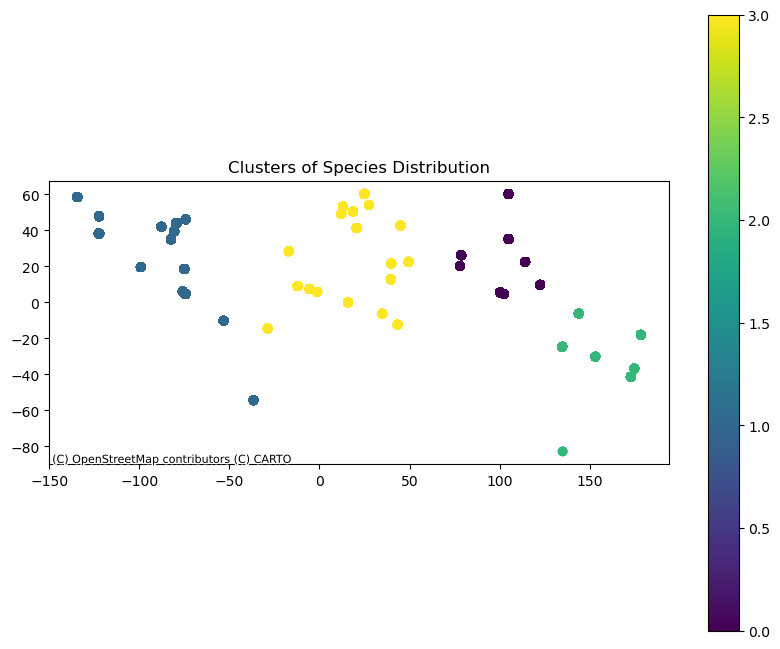

In [26]:

from sklearn.cluster import KMeans

# Drop duplicates based on species, latitude, and longitude
unique_species_location = final_dataset_cleaned.drop_duplicates(subset=['species', 'latitude', 'longitude'])

# Create a GeoDataFrame with unique species-location pairs
gdf = gpd.GeoDataFrame(unique_species_location, geometry=gpd.points_from_xy(unique_species_location.longitude, unique_species_location.latitude))
gdf.set_crs(epsg=4326, inplace=True)  # Set the CRS to WGS84 (EPSG:4326)

# Extract coordinates for clustering
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=0)  # Adjust the number of clusters (n_clusters) as needed
gdf['cluster_labels'] = kmeans.fit_predict(coords)

# Plot the GeoDataFrame with cluster labels
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='cluster_labels', cmap='viridis', legend=True, ax=ax)
plt.title('Clusters of Species Distribution')


# Add basemap
try:
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
except Exception as e:
    print(f"Error adding basemap: {e}")

plt.show()